In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from statsmodels.tsa.stattools import acovf
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error

Função que plota o resíduo, ACF e PACF da série temporal. Os principais parâmetros das função são a própria série e o número de lags desejado.

In [6]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh', title = 'Time Series Analysis Plots'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        plt.tight_layout()
    return
# _ = tsplot(best_mdl.resid, lags=max_lag, title = 'Residual - ARMA {}'.format(best_order))

# 1. Através de uma pesquisa na literatura, explique:

### a) As vantagens para utilização de modelos ARMA;

- Une características individuais dos processos AR (Autoregressive) e MA (Moving average);
- Várias bases de dados reais podem ser aproximadas a modelos ARMA de forma mais suave, indicando a necessidade de menos parâmetros quando comparado aos modelos AR e MA puros;
- Modelos que capturam bem o comportamente da série através da autocorrelação.

### b) As desvantagens para utilização de modelos ARMA;

- A série deve ser estacionária, ou seja, sem tendência, sazonalidade, além de possuir média e variância constantes. Se a série não for estacionária, deverá ser realizada a diferenciação. O uso de diferenciação já nos introduz ao conceito do modelo ARIMA(p,d,q);
- Para selecionar manualmente os parâmetros do modelo, é necessário conhecimento e experiência. São considerados modelos de difícil interpretabilidade.

### c) Principais técnicas de estimação dos parâmetros do modelo.

- Realizando um grid search com diferentes valores dos parâmetros (p e q) e verificando, através de alguma métrica de erro ou acurácia, qual modelo melhor se ajustou aos dados da série original;
- Analisando a tendência, sazonalidade e as funções de autocorrelação (ACF) e autocorrelação parcial (PACF).

### Fontes:

1. CHATFIELD, C. <b>Time Series Forecasting.</b> Chapman and Hall, 2001.
2. KATZ, R. SKAGGS, R. <b>On the Use of Autoregressive-Moving Average Processes to Model Meteorological Time Series.</b> Disponível em: <https://journals.ametsoc.org/doi/abs/10.1175/1520-0493%281981%29109%3C0479%3AOTUOAM%3E2.0.CO%3B2>
3. ARIMA Models. Galit Shmueli. <i>Link</i>: https://www.youtube.com/watch?v=0xHf-SJ9Z9U

# 2. Encontre um modelo ARMA(p,q) que melhor modela a série de chuva (chuva_fortaleza.xls). Justifique a sua escolha e a utilização de cada procedimento. (Utilize os correlogramas para encontrar os valores de p e q, e o teste ADF e KPSS para verificar estacionariedade).

In [7]:
data1 = pd.read_csv('chuva_fortaleza.csv')

### Teste de Estacionariedade (Augmented Dickey-Fuller e KPSS)

In [8]:
adf = adfuller(data1.iloc[:, 1].values)
print('ADF = %f.' % adf[0] ,'P-value = %f.' % adf[1],'\n')

ADF = -8.705081. P-value = 0.000000. 



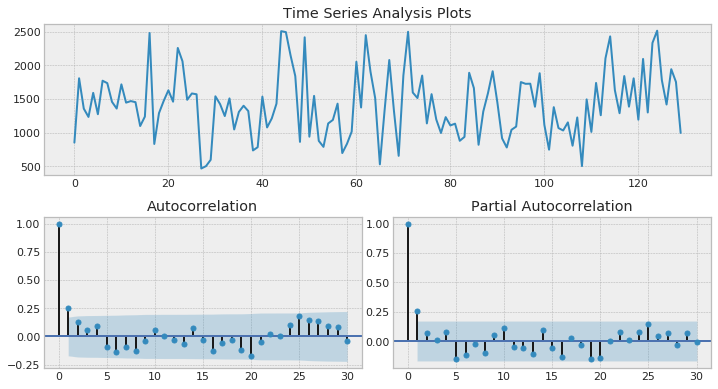

In [9]:
max_lag = 30
_ = tsplot(data1.iloc[:, 1].values, lags=max_lag)

Analisando os correlogramas e os testes estatísticos de estacionariedade, verifica-se que a série é estacionária. A seguir, serão estimados os parâmetros do modelo ARMA a partir do ACF e PACF:

- No ACF, apenas o lag 1 apresenta pico acima do intervalo de confiança. Logo, o parâmetro q = 1;
- No PACF, também apenas o lag 1 apresenta pico acima do intervalo. Logo, o parâmetro p = 1.

Portanto, o modelo ARMA(1,1) será construído a seguir na tentativa de modelar os dados da série.

### Modelo ARMA(1,1)

In [21]:
model = smt.ARMA(data1.iloc[:, 1].values, order=(1, 1)).fit()

A seguir será analisado a estimação do modelo.

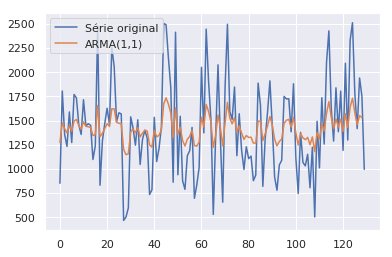

In [24]:
plt.plot(data1.iloc[:, 1].values, label = 'Série original')
plt.plot(model.fittedvalues[1:], label = 'ARMA(1,1)')
plt.legend()

# 3. Encontre um modelo ARMA(p,q) que melhor modela a série de preços de imóveis (sales_house.xls) e compare com a estimação por médias móveis e suavização exponencial. (Utilize o gridsearch para encontrar os valores de p e q, e o teste ADF e KPSS para verificar estacionariedade).

In [25]:
df = pd.read_csv('sales_house.csv')

### Teste de Estacionariedade (Augmented Dickey-Fuller e KPSS)

In [26]:
adf = adfuller(df.iloc[:, 1].values)
print('ADF = %f.' % adf[0] ,'P-value = %f.' % adf[1],'\n')

ADF = -1.269234. P-value = 0.643128. 



In [27]:
kpss(df.iloc[:, 1].values)

/home/CIN/jvcm/timeseriesenv/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.1743740467994027,
 0.1,
 13,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

A partir dos testes estatísticos ADF e KPSS, a série não é estacionária. Logo, será preciso diferenciá-la até que seja obtida uma série estacionária.

### 1ª Diferenciação:

In [28]:
data2 = df.Sales - df.Sales.shift()
data2 = data2.dropna()

In [29]:
adf = adfuller(data2)
print('ADF = %f.' % adf[0] ,'P-value = %f.' % adf[1],'\n')
kpss(data2)

ADF = -3.808600. P-value = 0.002821. 



/home/CIN/jvcm/timeseriesenv/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.10645409664108876,
 0.1,
 13,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Após a 1ª diferenciação, a série tornou-se estacionária (nível de significância de 5%).

### ARMA(p,q) - Grid search para encontrar os parâmetros p e q:

In [30]:
max_lag = 20

best_mse = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5] Para realizar o grid search dos parâmetros p e q.
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(data2, order=(i, j)).fit()
            tmp_mse = mean_squared_error(data2, tmp_mdl.fittedvalues)
            if tmp_mse < best_mse:
                best_mse = tmp_mse
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: 
            continue

/home/CIN/jvcm/timeseriesenv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/CIN/jvcm/timeseriesenv/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/CIN/jvcm/timeseriesenv/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_fu

In [31]:
print('O modelo que melhor modela a série é o ARMA {} , que possui MSE = {:6.2f}.'.format(best_order,best_mse))

O modelo que melhor modela a série é o ARMA (4, 4) , que possui MSE =  25.55.


### Médias Móveis - Grid search para encontrar o melhor h:

In [32]:
best_mse = np.inf 
best_h = None
best_mm = None

rng = range(2,31) # [2,3,4,5... 30] Para realizar o grid search dos parâmetros p e q.
for i in rng:
    try:
        tmp_mm = data2.rolling(window=i).mean()
        tmp_mm = tmp_mm.dropna()
        tmp_mse = mean_squared_error(data2.iloc[i-1:], tmp_mm)
        if tmp_mse < best_mse:
            best_mse = tmp_mse
            best_h = i
            best_mm = tmp_mm
    except: continue

print('MSE: {:6.2f} | Janela: {}'.format(best_mse, best_h))

MSE:  16.94 | Janela: 2


### Suavização exponencial

In [38]:
best_mse = np.inf 
best_alpha = None
best_suav = None

rng = np.arange(0.1, 1., 0.1)
for i in rng:
    try:
        rol =  data2.ewm(alpha = i)
        tmp_exp = rol.mean()
        tmp_mse = mean_squared_error(data2, tmp_exp)
        if tmp_mse < best_mse:
            best_mse = tmp_mse
            best_alpha = i
            best_suav = tmp_exp
    except: continue

print('MSE: {:6.2f} | Fator de suavização: {}'.format(best_mse, best_alpha))

MSE:   0.62 | Fator de suavização: 0.9


### Plot da série e modelos

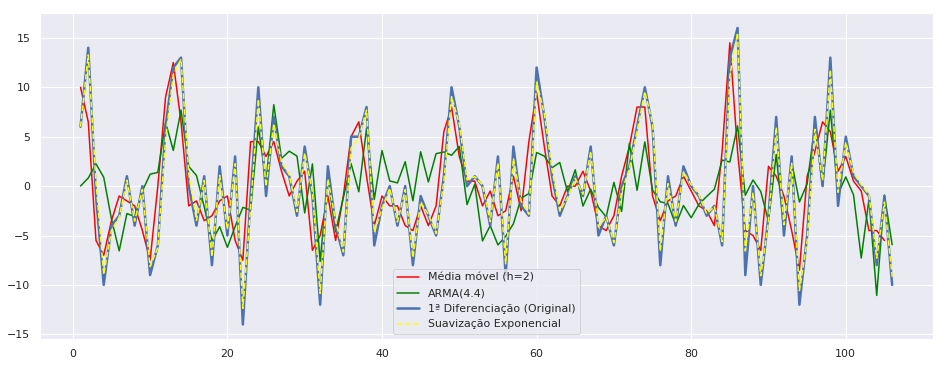

In [41]:
rcParams['figure.figsize'] = 16, 6
plt.plot(np.arange(best_h-1, len(data2)), best_mm, color = 'red', label = 'Média móvel (h={})'.format(best_h))
plt.plot(best_mdl.fittedvalues, label = 'ARMA(4.4)', color = 'green')
plt.plot(data2, label = '1ª Diferenciação (Original)', linewidth=2.5)
plt.plot(best_suav, label = 'Suavização Exponencial', color = 'yellow', linestyle = '--')
plt.legend()

Comparando pela métrica de Mean Squared Error (MSE), verifica-se que o modelo ARMA(4,4), encontrado no grid search, foi o pior dos modelos estimados. Analisando visualmente o plot da série diferenciada e a estimação de cada modelo, a suavização exponencial (com alpha = 0.9) se aproximou mais da série original.